In [1]:
from mofapy2.run.entry_point import entry_point
import anndata
import networkx as nx
import scanpy as sc
from matplotlib import rcParams
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
import palettable
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
from scipy import stats
fm.fontManager.ttflist += fm.createFontList(['/mnt/c/Users/FernandoZeng/Desktop/arial.ttf'])
matplotlib.rc('font', family='Arial')

In [3]:
def normalization(data):
    _range = np.max(abs(data))
    return data / _range

In [4]:
def get_weights(f,view,factor,scale=True):
  view_names=f['views']['views'][:]
  group_names=f['groups']['groups'][:]
  feature_names=np.array([f['features'][i][:] for i in view_names])
  sample_names=np.array([f['samples'][i][:] for i in group_names])
  f_name=feature_names[np.where(view_names==str.encode(view))[0][0]]
  f_w=f['expectations']['W'][view][factor-1]
  if scale==True:
    f_w=normalization(f_w)
  res=pd.DataFrame()
  res['feature']=f_name
  res['weights']=f_w
  res['abs_weights']=abs(f_w)
  res['sig']='+'
  res.loc[(res.weights<0),'sig'] = '-'

  return res

In [5]:
rna=anndata.read_h5ad("/mnt/d/FernandoZeng/MOFA_AD/data/model/rna_mofa_ret.h5ad")
atac=anndata.read_h5ad("/mnt/d/FernandoZeng/MOFA_AD/data/model/atac_mofa_ret.h5ad")

In [6]:
ret3= list(set(rna.obs.index).intersection(atac.obs.index))
len(ret3)

6008

In [7]:
rna_sex=rna[ret3][(rna[ret3].obs['Sample.ID']!='Sample-22') & (rna[ret3].obs['Sample.ID']!='Sample-27')]
for i in list(set(rna_sex.obs['cell_type'])):
  print(i,len(rna_sex.obs.loc[rna_sex.obs['cell_type']==i])/len(rna_sex.obs))

ASC 0.06474700399467377
PER.END 0.0039946737683089215
INH 0.05858854860186418
EX 0.07789613848202397
MG 0.046937416777629824
OPC 0.027796271637816245
ODC 0.7200399467376831


In [8]:
atac_sex=atac[ret3][(atac[ret3].obs['Sample.ID']!='Sample-22') & (atac[ret3].obs['Sample.ID']!='Sample-27')]
for i in list(set(atac_sex.obs['cell_type'])):
  print(i,len(atac_sex.obs.loc[atac_sex.obs['cell_type']==i])/len(atac_sex.obs))

ASC 0.06541278295605858
PER.END 0.003828229027962716
INH 0.05858854860186418
EX 0.07440079893475367
MG 0.051098535286284955
OPC 0.02796271637816245
ODC 0.7187083888149135


In [9]:
ret_sex= list(set(rna_sex.obs.index).intersection(atac_sex.obs.index))
len(ret_sex)

6008

In [10]:
test=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/mofa_sex_asc_meta2.csv')
res_mg=rna_sex[test[test.columns[0]]]
res_mg

View of AnnData object with n_obs × n_vars = 376 × 3066
    obs: 'cell_type', 'Sample.ID', 'Batch', 'Age', 'Sex', 'PMI', 'Tangle.Stage', 'Plaque.Stage', 'Diagnosis', 'RIN', 'delli', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'

In [11]:
res_mg_atac=atac_sex[test[test.columns[0]]]
res_mg_atac

View of AnnData object with n_obs × n_vars = 376 × 20030
    obs: 'cell_type', 'Sample.ID', 'Batch', 'Age', 'Sex', 'PMI', 'Tangle.Stage', 'Plaque.Stage', 'Diagnosis', 'RIN', 'delli', 'nb_features', 'log_nb_features'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [12]:
f_mg = h5py.File('/mnt/d/FernandoZeng/MOFA_AD/data/asc/mofa_sex_asc_50factor2.hdf5','r')   #打开h5文件
# 可以查看所有的主键
for key in f_mg.keys():
    print(f_mg[key].name)

/data
/expectations
/features
/groups
/intercepts
/model_options
/samples
/training_opts
/training_stats
/variance_explained
/views


In [13]:
for i in range(f_mg['expectations']['Z']['group0'].shape[0]):
  res_mg.obs['factor{0}'.format(i+1)]=f_mg['expectations']['Z']['group0'][i]

Trying to set attribute `.obs` of view, copying.


In [14]:
for i in range(f_mg['expectations']['Z']['group0'].shape[0]):
  res_mg_atac.obs['factor{0}'.format(i+1)]=f_mg['expectations']['Z']['group0'][i]

Trying to set attribute `.obs` of view, copying.


In [15]:
variance=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/variance_explained.csv')
corr=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/correlate_factors.csv')
variance.index=corr.index
variance.head()

,rna,atac
Factor1,1.120983,2.776116
Factor2,0.143909,3.679852
Factor3,3.348040,0.083702
Factor4,0.133514,2.254355
Factor5,0.087929,1.657680


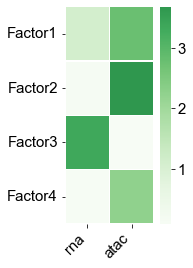

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2,4))         # Sample figsize in inches
new_blues=sns.color_palette("Greens", 1000)[0:700]
g=sns.heatmap(variance.loc[['Factor1','Factor2','Factor3','Factor4']],
      cmap=new_blues,
      linewidths=.5,annot_kws={"size": 15},ax=ax
      )
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15,rotation=45, horizontalalignment='right',)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15,rotation=360)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

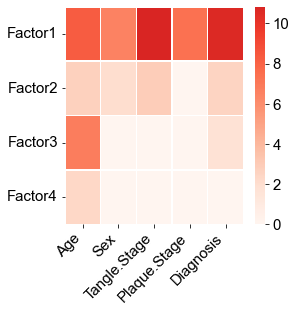

In [17]:
fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
new_reds=sns.color_palette("Reds", 1000)[0:700]
g=sns.heatmap(corr.loc[['Factor1','Factor2','Factor3','Factor4']],
      cmap=new_reds, 
      linewidths=.5,annot_kws={"size": 15},ax=ax,
      )

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15,rotation=45, horizontalalignment='right',)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 15,rotation=360)
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

In [18]:
res1=get_weights(f_mg,'rna',1)
xl=[]
for i in res1['feature'].values:
  xl.append(bytes.decode(i).replace('Mutation',''))
res1['feature']=xl
res1.head()

,feature,weights,abs_weights,sig
0,HES4,0.132595,0.132595,+
1,SKI,0.029003,0.029003,+
2,PEX10,-0.001557,0.001557,-
3,TNFRSF14,0.012549,0.012549,+
4,LINC00982,-0.061185,0.061185,-


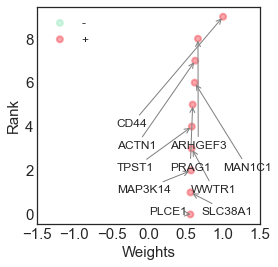

In [19]:
import matplotlib.pyplot as plt


def plot_high_weight(res,n_feature=10):
  plt.style.use('seaborn-white')
  #定义字体
  font1={
    'size':15,
  }
  #排序
  res=res.sort_values('abs_weights',ascending=False)
  res_p=res.iloc[:n_feature].sort_values('weights',ascending=True)
  #获取xy
  x=res_p['weights'].values
  y=range(len(res_p['weights']))

  #定义图像大小
  pp=plt.figure(figsize=(4,4))
  ax=pp.add_subplot(1,1,1)
  #定义+的起点
  max_start=len(res_p)-len(res_p.loc[res_p['sig']=='+'])
  #绘制散点图
  ax.scatter(x[:max_start],y[:max_start],c="#a2ebc4",alpha=0.5,linewidths=(np.zeros(len(res_p)-max_start)+2))
  ax.scatter(x[max_start:],y[max_start:],c="#f2535d",alpha=0.5,linewidths=(np.zeros(len(res_p)-max_start)+2))
  
  #定义文字位置
  ti=len(res_p)-len(res_p.loc[res_p['sig']=='+']) #+
  fi=0 #-
  ti_max=7 #换行标记
  fi_max=7
  for i in range(10):
    #如果为-
    if res_p['sig'].iloc[i]=='-':
      #计算文字长度
      zl=len(res_p['feature'].iloc[i])
      #计算该行剩余长度
      fi_max-=zl

      ax.annotate(res_p['feature'].iloc[i], xy=(x[i],y[i]), xytext=(-0.7+fi_max/7,fi),weight='heavy',
               #bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),
               arrowprops=dict(arrowstyle='->',color='grey'),size=12)
      #如果剩余长度不足0，那么换行
      if fi_max<0:
        fi_max=10
        fi+=1
    else:
      zl=len(res_p['feature'].iloc[i])
      ax.annotate(res_p['feature'].iloc[i], xy=(x[i],y[i]), xytext=(1-ti_max/7,ti),weight='heavy',
               #bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),
               arrowprops=dict(arrowstyle='->',color='grey'),size=12)
      ti_max-=zl
      if ti_max<0:
        ti_max=10
        ti+=1


  plt.xlim(-1.5,1.5)
  plt.yticks(fontsize=15)
  plt.xticks(fontsize=15)
  #设置图注
  plt.legend(["-","+"],loc='best',fontsize=12)
  #设置横纵标题
  ax.set_ylabel('Rank',font1)                   
  ax.set_xlabel('Weights',font1)

plot_high_weight(res1,10)

In [20]:
res1_atac=get_weights(f_mg,'atac',1)
xl=[]
for i in res1_atac['feature'].values:
  xl.append(bytes.decode(i).replace('Mutation',''))
res1_atac['feature']=xl
res1_atac.head()

,feature,weights,abs_weights,sig
0,chr1_190849_191920,-0.013703,0.013703,-
1,chr1_633740_634682,-0.000996,0.000996,-
2,chr1_778234_779324,-0.015239,0.015239,-
3,chr1_958857_961284,0.116873,0.116873,+
4,chr1_998974_1002246,-0.008020,0.008020,-


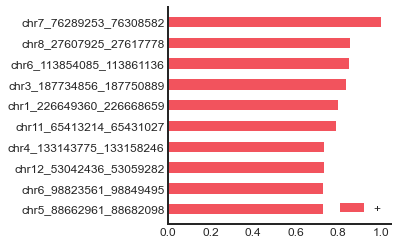

In [21]:
def plot_weight_bar(res,nfeature):
  res=res.sort_values('abs_weights',ascending=False)
  res_p=res.iloc[:nfeature].sort_values('abs_weights',ascending=True)


  pp=plt.figure(figsize=(4,4))
  ax=pp.add_subplot(1,1,1)

  for i in range(len(res_p)):
    pre_p=res_p.iloc[i]
    if(pre_p['sig']=='-'):
      l1=ax.barh(y=pre_p['feature'],width=pre_p['abs_weights'],color='#a2ebc4',height=0.5)
    if(pre_p['sig']=='+'):
      l2=ax.barh(y=pre_p['feature'],width=pre_p['abs_weights'],color='#f2535d',height=0.5)
  if 'l1' not in locals():
    plt.legend(handles=[l2],labels=["+"],loc='best',fontsize=12)
  elif 'l2' not in locals():
    plt.legend(handles=[l1],labels=["-"],loc='best',fontsize=12)
  else:
    plt.legend(handles=[l1,l2],labels=["-","+"],loc='best',fontsize=12)
  plt.yticks(fontsize=12)
  plt.xticks(fontsize=12)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_linewidth(2)
  ax.spines['left'].set_linewidth(2)

plot_weight_bar(res1_atac,10)

In [22]:
def get_viodata_rna(res,genelist):
  vio_data=pd.DataFrame()
  print(len(res[res.obs['Diagnosis']=='AD'].X.T[0]),len(res[res.obs['Diagnosis']=='Control'].X.T[0]))
  for i in genelist:
    test_1=pd.DataFrame()
    test_1['value']=res[res.obs['Diagnosis']=='AD'][:,i].X.T[0]
    test_1['gene']=[i for i in [i]*len(test_1)]
    test_1['type']=[i for i in ['ad']*len(test_1)]

    test_2=pd.DataFrame()
    test_2['value']=res[res.obs['Diagnosis']=='Control'][:,i].X.T[0]
    test_2['gene']=[i for i in [i]*len(test_2)]
    test_2['type']=[i for i in ['ctrl']*len(test_2)]
  
    vio_data=pd.concat([vio_data,test_1],ignore_index=True)
    vio_data=pd.concat([vio_data,test_2],ignore_index=True)
  return vio_data

In [23]:
def get_viodata_atac(res,genelist):
  vio_data=pd.DataFrame()
  print(len(res[res.obs['Diagnosis']=='AD'].X.todense().T[0]),len(res[res.obs['Diagnosis']=='Control'].X.todense().T[0]))
  for i in genelist:
    test_1=pd.DataFrame()
    test_1['value']=np.array(res[res.obs['Diagnosis']=='AD'][:,i].X.todense()).T[0]
    test_1['gene']=[i for i in [i]*len(test_1)]
    test_1['type']=[i for i in ['ad']*len(test_1)]

    test_2=pd.DataFrame()
    test_2['value']=np.array(res[res.obs['Diagnosis']=='Control'][:,i].X.todense()).T[0]
    test_2['gene']=[i for i in [i]*len(test_2)]
    test_2['type']=[i for i in ['ctrl']*len(test_2)]
  
    vio_data=pd.concat([vio_data,test_1],ignore_index=True)
    vio_data=pd.concat([vio_data,test_2],ignore_index=True)
  return vio_data

In [24]:
mg_res=res1.sort_values('abs_weights',ascending=False)
mg_res.set_index(mg_res.columns[0],inplace=True)
mg_res.head()

,weights,abs_weights,sig
feature,,,
CD44,1.000000,1.000000,+
ARHGEF3,0.662497,0.662497,+
ACTN1,0.625394,0.625394,+
MAN1C1,0.619061,0.619061,+
PRAG1,0.591399,0.591399,+


168 208
9.510875834917132e-16 ***
3.7728751020436616e-17 ***
5.673826501343588e-07 ***
2.406163535785158e-06 ***
0.0002821722212979416 ***


Text(0, 0.5, 'Expression')

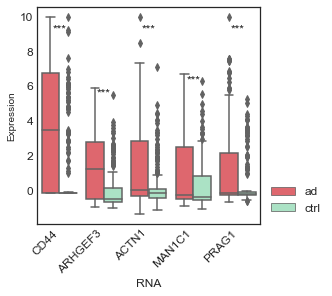

In [25]:
from scipy import stats
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(4,4))

plot_data=get_viodata_rna(res_mg,list(mg_res.head(5).index.values))

g=sns.boxplot(x="gene", y="value", hue='type',data=plot_data, 
        palette=["#f2535d","#a2ebc4"],ax=ax,     
              )
c=0
for i in list(mg_res.head(5).index.values):
    ttest = stats.ttest_ind(plot_data.loc[plot_data['gene'].isin([i]) & plot_data['type'].isin(['ctrl'])]['value'], plot_data.loc[plot_data['gene'].isin([i]) & plot_data['type'].isin(['ad'])]['value'])
    max_value=plot_data[plot_data['gene'].isin([i])]['value'].max()
    if(ttest[1]<0.001):
        xing="***"   
    elif(ttest[1]<0.01):
        xing="**"
    elif(ttest[1]<0.05):
        xing="*"
    else:
        xing=' '
    print(ttest[1],xing)
    g.text(c,max_value*0.9, xing,ha='center', va='bottom', fontsize=12)
    c+=1

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15,rotation=45, horizontalalignment='right',)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#设置图注
plt.legend(bbox_to_anchor=(1, 0), loc=3,fontsize=12)

plt.xlabel('RNA',fontsize=12)
plt.ylabel('Expression')

In [26]:
proper_data=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/proper/PROPER_v1.csv')
proper_data.head()

,Gene1,Gene2,Cell line specificity,Read count,Odds ratio,BH-corrected p-value,Potential background contamination
0,KNOP1,IQCK,shared,104020,5.802677e+12,0.0,0
1,RPS4X,NPM1,HEK,22103,4.071008e+00,0.0,0
2,PTMA,NPM1,shared,21490,2.575209e+00,0.0,0
3,NPM1,HNRNPA2B1,shared,19854,1.959955e+00,0.0,0
4,PTMA,HMGB1,Jurkat,16717,3.497662e+00,0.0,0


In [27]:
b=proper_data[proper_data['Gene1'].isin(list(mg_res.head(10).index.values))]
b.head()

,Gene1,Gene2,Cell line specificity,Read count,Odds ratio,BH-corrected p-value,Potential background contamination
12766,SLC38A1,HNRNPA2B1,shared,245,2.562141,4.572748e-50,0
13008,SLC38A1,NPM1,shared,242,1.798186,4.161808e-19,0
13149,CD44,APP,HUVEC,241,7.579103,4.096366e-293,0
20882,SLC38A1,PTMA,shared,175,2.181257,8.862493e-25,0
22944,WWTR1,HNRNPA2B1,HUVEC,164,3.900603,2.964876e-74,0


In [28]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(set(b['Gene1'].tolist()+b['Gene2'].tolist()))

#Connect nodes
for i in b.index:
  col_label = b.loc[i]['Gene1']
  row_label = b.loc[i]['Gene2']
  G.add_edge(col_label,row_label)

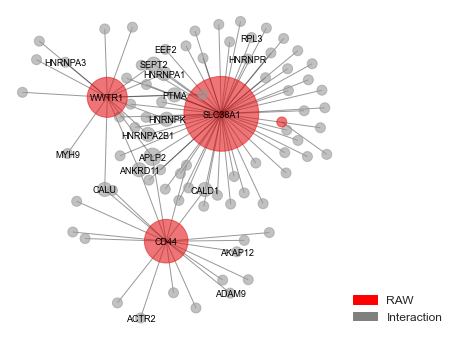

In [29]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(418220)
G1=G

p=dict(G1.nodes)
for i in p.keys():
  if i in b['Gene1'].values:
    p[i]=0
  elif i in b['Gene2'].values:
    p[i]=1
  else:
    p[i]=2

pos = nx.spring_layout(G1, scale=50, k=(len(list(set(b['Gene1'].values.tolist()+b['Gene2'].values.tolist())))//20)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(6, 6))
plt.style.use('seaborn-white')
#plt.rc('font', family="serif")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*100 for v in G1],
    node_color=list(p.values()),
    cmap='Set1',
    alpha=0.6,
    linewidths=1,
)
hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:20]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=9,
    font_weight='bold',
)

labels = ['RAW', 'Interaction']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = ['Red','Grey']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(1, 0), loc=3,fontsize=12)


In [30]:
mg_res_atac=res1_atac.sort_values('abs_weights',ascending=False)
mg_res_atac.set_index(mg_res_atac.columns[0],inplace=True)
mg_res_atac.head()

,weights,abs_weights,sig
feature,,,
chr7_76289253_76308582,1.000000,1.000000,+
chr8_27607925_27617778,0.854928,0.854928,+
chr6_113854085_113861136,0.851547,0.851547,+
chr3_187734856_187750889,0.835384,0.835384,+
chr1_226649360_226668659,0.800402,0.800402,+


In [31]:
res_mg_atac.var.loc[mg_res_atac.loc[mg_res_atac['abs_weights']>0.8].index.values]

,feature_types,genome,chrom,chromStart,chromEnd,n_counts,transcript_annotation,n_cells,commonness,prop_shared_cells,variability_score
chr7_76289253_76308582,Peaks,GRCh38,chr7,76289253,76308582,58977.0,intergenic,2251.0,2251.0,0.363886,0.863886
chr8_27607925_27617778,Peaks,GRCh38,chr8,27607925,27617778,51040.0,RP11-16P20.3;CCDC25,2165.0,2165.0,0.349984,0.849984
chr6_113854085_113861136,Peaks,GRCh38,chr6,113854085,113861136,43109.0,RP11-346D19.1,1818.0,1818.0,0.293889,0.793889
chr3_187734856_187750889,Peaks,GRCh38,chr3,187734856,187750889,75054.0,intergenic,3457.0,3457.0,0.558843,0.941157
chr1_226649360_226668659,Peaks,GRCh38,chr1,226649360,226668659,45997.0,intergenic,1709.0,1709.0,0.276269,0.776269


(0, -0.25)


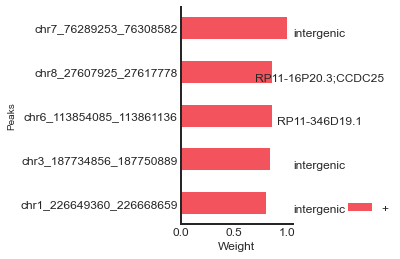

In [33]:
def plot_weight_bar(res,nfeature):
  res=res.sort_values('abs_weights',ascending=False)
  res_p=res.iloc[:nfeature].sort_values('abs_weights',ascending=True)


  pp=plt.figure(figsize=(2,4))
  ax=pp.add_subplot(1,1,1)

  for i in range(len(res_p)):
    pre_p=res_p.iloc[i]
    if(pre_p['sig']=='-'):
      l1=ax.barh(y=pre_p['feature'],width=pre_p['abs_weights'],color='#a2ebc4',height=0.5)
      #print(l1.patches[0].get_x())
      ax.text(1.3,ax.patches[i].xy[1], res_mg_atac.var.loc[pre_p['feature'],'transcript_annotation'],ha='center', va='bottom', fontsize=12)
    if(pre_p['sig']=='+'):
      l2=ax.barh(y=pre_p['feature'],width=pre_p['abs_weights'],color='#f2535d',height=0.5)
      #print(l2.patches[0].get_x())
      ax.text(1.3,ax.patches[i].xy[1], res_mg_atac.var.loc[pre_p['feature'],'transcript_annotation'],ha='center', va='bottom', fontsize=12)
  if 'l1' not in locals():
    plt.legend(handles=[l2],labels=["+"],bbox_to_anchor=(1.4, 0), loc=3,fontsize=12)
  elif 'l2' not in locals():
    plt.legend(handles=[l1],labels=["-"],bbox_to_anchor=(1.4, 0), loc=3,fontsize=12)
  else:
    plt.legend(handles=[l1,l2],labels=["-","+"],bbox_to_anchor=(1, 0), loc=3,fontsize=12)
  
  plt.yticks(fontsize=12)
  plt.xticks(fontsize=12)

  print(ax.patches[0].xy)

  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_linewidth(2)
  ax.spines['left'].set_linewidth(2)

  plt.xlabel('Weight',fontsize=12)
  plt.ylabel('Peaks')
plot_weight_bar(res1_atac,5)

1 1
chr7_76289253_76308582 0.0025435037789586184 **
chr8_27607925_27617778 0.0004464469986228496 ***
chr6_113854085_113861136 0.031433146269689224 *
chr3_187734856_187750889 0.005956890791452447 **
chr1_226649360_226668659 0.006100951471176157 **


Text(0, 0.5, 'Counts')

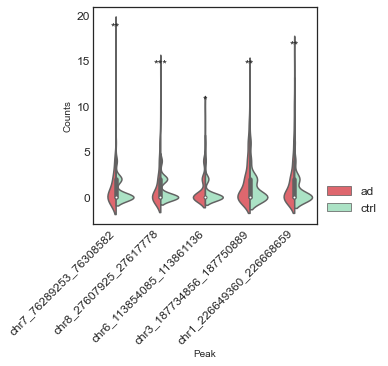

In [34]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(4,4))

plot_data=get_viodata_atac(res_mg_atac,list(mg_res_atac.head(5).index.values))

g=sns.violinplot(x="gene", y="value", hue='type',data=plot_data, 
        split=True,inner="box",palette=["#f2535d","#a2ebc4"],ax=ax,
        #saturation=1
        )

c=0
for i in list(mg_res_atac.head(5).index.values):
    ttest = stats.ttest_ind(plot_data.loc[plot_data['gene'].isin([i]) & plot_data['type'].isin(['ctrl'])]['value'], plot_data.loc[plot_data['gene'].isin([i]) & plot_data['type'].isin(['ad'])]['value'])
    max_value=plot_data[plot_data['gene'].isin([i])]['value'].max()
    if(ttest[1]<0.001):
        xing="***"   
    elif(ttest[1]<0.01):
        xing="**"
    elif(ttest[1]<0.05):
        xing="*"
    else:
        xing=' '
    print(i,ttest[1],xing)
    g.text(c,max_value*1.01, xing,ha='center', va='bottom', fontsize=12)
    c+=1

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15,rotation=45, horizontalalignment='right',)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(bbox_to_anchor=(1, 0), loc=3,fontsize=12)

plt.xlabel('Peak')
plt.ylabel('Counts')

Text(0, 0.5, 'Factor')

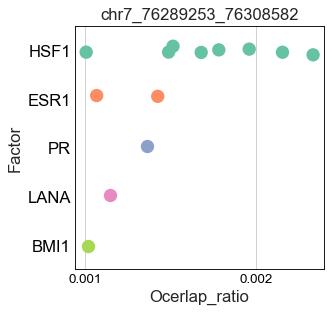

In [52]:
from matplotlib.pyplot import MultipleLocator
tf_csv=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/chr7_76289253_76308582_hg38_tf_result.csv')
fig, ax = plt.subplots(figsize=(4,4))
tf_csv1=tf_csv.loc[tf_csv['Overlap_ratio']>0.001]
g=sns.stripplot(x=tf_csv1["Overlap_ratio"],y=tf_csv1['Factor'],palette='Set2',size=12)
plt.title('chr7_76289253_76308582',fontdict={'size':15})
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
g.xaxis.set_major_locator(MultipleLocator(0.001))
plt.xlabel('Ocerlap_ratio',fontdict={'size':15})
plt.ylabel('Factor',fontdict={'size':15})

Text(0, 0.5, 'Factor')

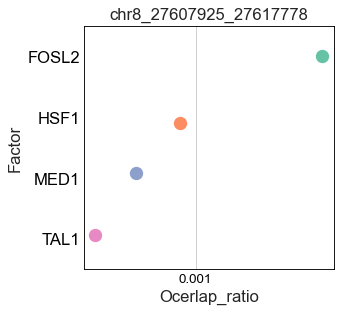

In [53]:
from matplotlib.pyplot import MultipleLocator
tf_csv=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/chr8_27607925_27617778_hg38_tf_result.csv')
fig, ax = plt.subplots(figsize=(4,4))
tf_csv1=tf_csv.loc[tf_csv['Overlap_ratio']>0.0008]
g=sns.stripplot(x=tf_csv1["Overlap_ratio"],y=tf_csv1['Factor'],palette='Set2',size=12)
plt.title('chr8_27607925_27617778',fontdict={'size':15})
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
g.xaxis.set_major_locator(MultipleLocator(0.001))
plt.xlabel('Ocerlap_ratio',fontdict={'size':15})
plt.ylabel('Factor',fontdict={'size':15})

Text(0, 0.5, 'Factor')

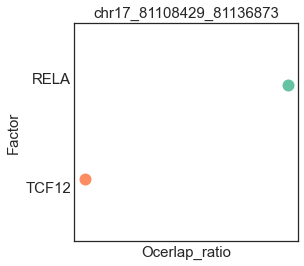

In [39]:
from matplotlib.pyplot import MultipleLocator
tf_csv=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/chr1_226649360_226668659_hg38_tf_result.csv')
fig, ax = plt.subplots(figsize=(4,4))
tf_csv1=tf_csv.loc[tf_csv['Overlap_ratio']>0.001]
g=sns.stripplot(x=tf_csv1["Overlap_ratio"],y=tf_csv1['Factor'],palette='Set2',size=12)
plt.title('chr17_81108429_81136873',fontdict={'size':15})
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
g.xaxis.set_major_locator(MultipleLocator(0.001))
plt.xlabel('Ocerlap_ratio',fontdict={'size':15})
plt.ylabel('Factor',fontdict={'size':15})

Text(0, 0.5, 'Factor')

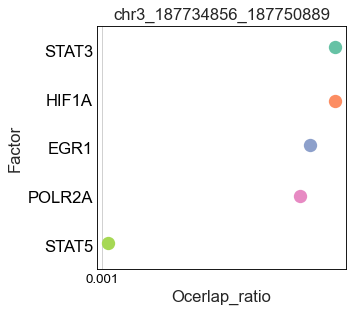

In [54]:
from matplotlib.pyplot import MultipleLocator
tf_csv=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/chr3_187734856_187750889_hg38_tf_result.csv')
fig, ax = plt.subplots(figsize=(4,4))
tf_csv1=tf_csv.loc[tf_csv['Overlap_ratio']>0.001]
g=sns.stripplot(x=tf_csv1["Overlap_ratio"],y=tf_csv1['Factor'],palette='Set2',size=12)
plt.title('chr3_187734856_187750889',fontdict={'size':15})
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
g.xaxis.set_major_locator(MultipleLocator(0.001))
plt.xlabel('Ocerlap_ratio',fontdict={'size':15})
plt.ylabel('Factor',fontdict={'size':15})

Text(0, 0.5, 'Factor')

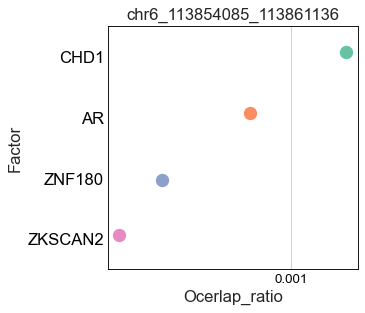

In [55]:
from matplotlib.pyplot import MultipleLocator
tf_csv=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/asc/chr6_113854085_113861136_hg38_tf_result.csv')
fig, ax = plt.subplots(figsize=(4,4))
tf_csv1=tf_csv.loc[tf_csv['Overlap_ratio']>0.0008]
g=sns.stripplot(x=tf_csv1["Overlap_ratio"],y=tf_csv1['Factor'],palette='Set2',size=12)
plt.title('chr6_113854085_113861136',fontdict={'size':15})
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
g.xaxis.set_major_locator(MultipleLocator(0.001))
plt.xlabel('Ocerlap_ratio',fontdict={'size':15})
plt.ylabel('Factor',fontdict={'size':15})

In [43]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.9


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


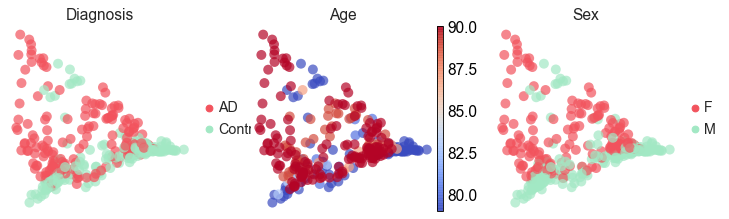

In [44]:
sc.pp.neighbors(res_mg, metric="cosine")
sc.tl.umap(res_mg,random_state=41822099)
scnmt=['#f2535d','#a2e8c4','#e5e24f','#6aafda','#c76fc7','#c4425d','#f48a3d']
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=[3,3])
sc.pl.umap(res_mg, color=["Diagnosis","Age","Sex",], wspace=0.2, palette=scnmt,
      #title=['RNA_AD','ASC/ODC','MG/-','OPC/-','INH/EX'],ncols=5,
      #title=['RNA_AD','Factor1','Factor2','Factor6','Factor7'],ncols=5,
      cmap='coolwarm',frameon=False,add_outline=True,outline_color=('white','white'),
           
      )

In [49]:
!pip install python-igraph

     |████████████████████████████████| 3.1 MB 916 kB/s eta 0:00:01


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99011284 0.9830709  0.96578    0.96035844 0.9514977
     0.9427981  0.9423569  0.93028146 0.92791677 0.9190561  0.915043
     0.9066434  0.9033144  0.89319223]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout

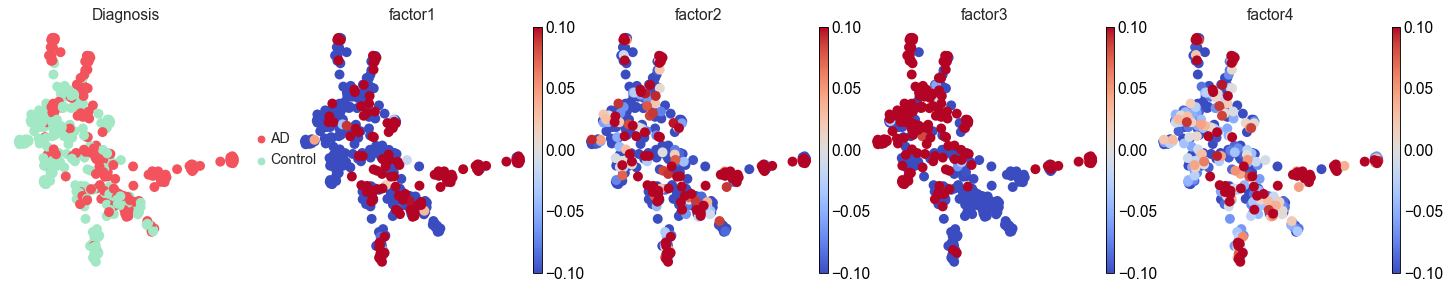

In [45]:
adata=res_mg
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata,random_state=41822099)
sc.settings.set_figure_params(dpi=80,figsize=[4,4],dpi_save=300)
sc.pl.draw_graph(adata,palette=scnmt,frameon=False,
          color=["Diagnosis","factor1","factor2","factor3","factor4"], wspace=0.1, ncols=5,
      #title=['RNA_AD','ASC/ODC','MG/-','OPC/-','INH/EX'],
      #title=['RNA_AD','Factor1','Factor2','Factor6','Factor7'],ncols=5,
      cmap='coolwarm',vmin=-0.1,vmax=0.1,save='sfig_asc.png')

In [51]:
!pip install leidenalg

     |████████████████████████████████| 1.4 MB 18 kB/s eta 0:00:01


In [46]:
stem_marker=pd.read_csv('/mnt/d/FernandoZeng/MOFA_AD/data/CellMarker/neuron_stem_cell.csv')
stem=stem_marker['Cell Marker'].values
for i in res_mg.var.index.values:
  if i in stem:
    print(i)

PAX6
LGR5
SOX9


running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


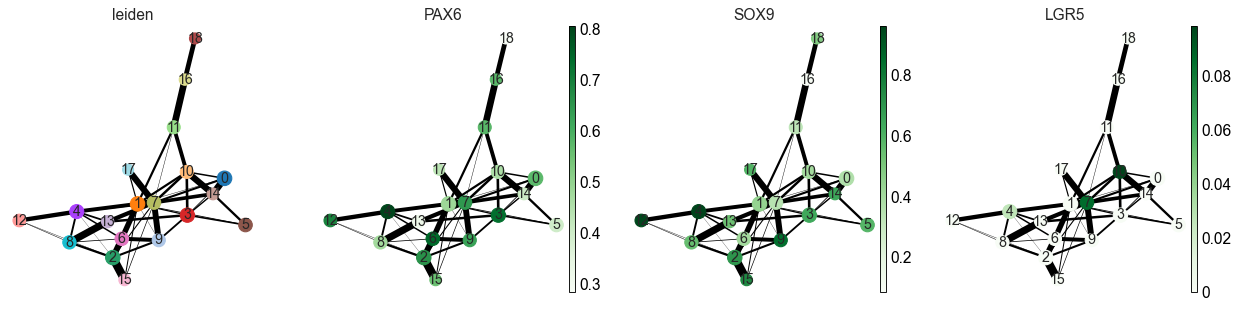

In [47]:
sc.tl.leiden(adata, resolution=1.0,random_state=41826060)
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden','PAX6','SOX9','LGR5'],cmap='Greens',frameon=False,save='sfig_asc_1.png')

In [48]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '10')[0]

In [49]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


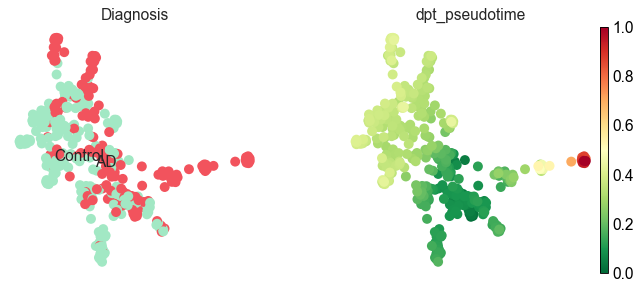

In [50]:
sc.set_figure_params(dpi=80,dpi_save=300,figsize=[4,4],color_map='RdYlGn_r')
sc.pl.draw_graph(adata, color=['Diagnosis','dpt_pseudotime'], 
          legend_loc='on data',
          add_outline=False,frameon=False,)

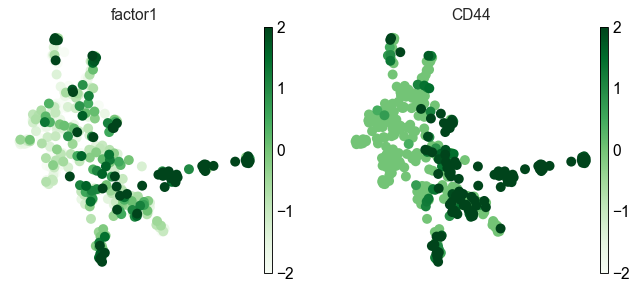

In [51]:
sc.set_figure_params(dpi=80,dpi_save=300,figsize=[4,4],color_map='summer')
sc.pl.draw_graph(adata, color=['factor1','CD44'], 
          vmin=-2,vmax=2, legend_loc='on data',cmap='Greens',
          add_outline=False,frameon=False,)